In [2]:
import os
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch import optim
import numpy as np
from collections import OrderedDict
import time
import random
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
#synth_data = open("my_10k_synths.csv", "r").readlines()
#synth_data = open("rating_10k_synths.csv", "r").readlines()
synth_data = open("arjall_10k_synths.csv", "r").readlines()


train_test_percentage = 0.90
cutoff = int(train_test_percentage * len(synth_data))

# stupid extract data from csv
# organized by:
#  song_name | num of plays | [values...]
lines = [l.replace('\n', '').split('\t') for l in synth_data]

random.shuffle(lines)

# 163 - 259
my_x = [[float(i) for i in l[2+163:2+259]] for l in lines]

# TODO: put back
#my_x = [[float(i) for i in l[2:]] for l in lines]
my_y = [float(l[1]) for l in lines]
my_y_max = np.amax(my_y)

my_y = [[(y/my_y_max)**(0.4)] for y in my_y]

# splice dataset
train_x = my_x[:cutoff]
train_y = my_y[:cutoff]
test_x = my_x[cutoff:]
test_y = my_y[cutoff:]

# prepare tensors
tensor_train_x = torch.Tensor(train_x) # transform to torch tensor
tensor_train_y = torch.Tensor(train_y)
tensor_test_x = torch.Tensor(test_x) # transform to torch tensor
tensor_test_y = torch.Tensor(test_y)

train_dataset = TensorDataset(tensor_train_x,tensor_train_y) # create your datset
train_dataloader = DataLoader(train_dataset) # create your dataloader
test_dataset = TensorDataset(tensor_test_x,tensor_test_y) # create your datset
test_dataloader = DataLoader(test_dataset) # create your dataloader


(array([1.615e+03, 3.021e+03, 1.464e+03, 9.040e+02, 7.020e+02, 5.840e+02,
        4.210e+02, 3.340e+02, 2.370e+02, 1.560e+02, 1.090e+02, 8.100e+01,
        5.000e+01, 2.900e+01, 1.200e+01, 1.000e+01, 9.000e+00, 1.000e+00,
        3.000e+00, 2.000e+00]),
 array([2.94787753e-04, 5.02800484e-02, 1.00265309e-01, 1.50250570e-01,
        2.00235830e-01, 2.50221091e-01, 3.00206351e-01, 3.50191612e-01,
        4.00176873e-01, 4.50162133e-01, 5.00147394e-01, 5.50132654e-01,
        6.00117915e-01, 6.50103176e-01, 7.00088436e-01, 7.50073697e-01,
        8.00058958e-01, 8.50044218e-01, 9.00029479e-01, 9.50014739e-01,
        1.00000000e+00]),
 <BarContainer object of 20 artists>)

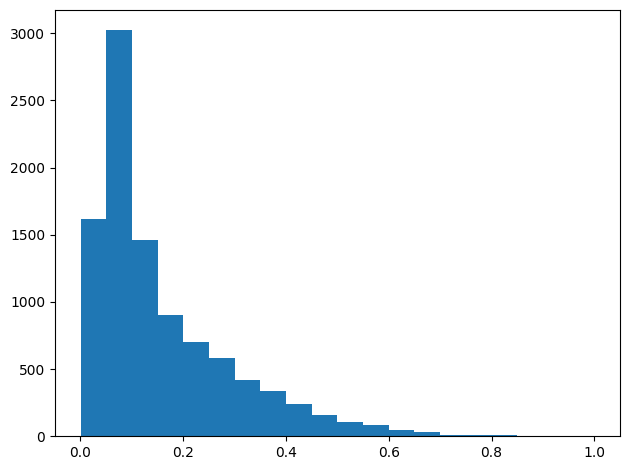

In [4]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs.hist([float(l[0]) for l in my_y], bins=20)

In [5]:
# evaluate a single tensor
def test_model(target):
    #X = torch.rand(1, 527, 1, device=device)
    #target = cutoff + 1
    X = torch.tensor(my_x[target])
    start = time.perf_counter_ns()
    #print(X.shape)
    logits = model(X)
    end = time.perf_counter_ns()
    print(f"Testing took: {(end - start)/1000000}ms")
    print(f"index[{target}] : {logits[0]:>0.4f} vs {my_y[target][0]:>0.4f}")
    #print(f"Predicted class: {y_pred}")

In [6]:
def describe_model(model):
    print(f"Model structure: {model}\n\n")

    for name, param in model.named_parameters():
        print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

In [7]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if batch % 1 == 0:
        loss, current = loss.item(), batch * len(X)
        #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

#pdist = torch.nn.PairwiseDistance(p=2)
def validate_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset) // int(1)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, errors = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            #print(f"Got pred: {pred.sum().item()}\tfor y: {y[0]}")
            test_loss += loss_fn(pred, y).item()
            errors += (abs(pred.sum().item() - y[0]))
    test_loss /= num_batches
    errors /= size
    correct = 1 - errors
    if progress % 1 == 0 or progress == 0:
        result = str(
            f"Epoch {str(progress).zfill(2)}  "
            #f"Accuracy: {(100 * correct):>0.1f}%  "
            f"Avg loss: {test_loss:>8f}  [{'X'*int(50*correct)}{'-'*int(50*(1-correct))}]"
        )
        print(result)
    return test_loss

In [8]:
def export_model(expmodel):
    dummy_input = torch.randn(1, 1, 96)
    torch.onnx.export(expmodel,
                 dummy_input,
                 "tridonn.onnx",
                 verbose=True,
                 input_names=["dense1"],
                 output_names=["outact"],
                 export_params=True,
                 )

In [9]:
def rate_file(filename):
    rate_file = open(filename, "r").readlines()
    rate_lines = [l.replace('\n', '').split('\t') for l in rate_file]

    # 163
    my_test_x = [[float(i) for i in l[1+163:1+259]] for l in rate_lines[1:]]
    song_names = [l[0] for l in rate_lines[1:]]
    
    #print("Song ratings: [0-1]")
    
    results = {}
    
    model.eval()
    
    with torch.no_grad():
        for i in range(len(my_test_x)):
            X = torch.tensor(my_test_x[i])
            song_name = song_names[i].split('/')[-1]
            logits = model(X)
            #end = time.perf_counter_ns()
            #print(f"Testing took: {(end - start)/1000000}ms")
            #print(f"index[{target}] : {logits[0]:>0.4f} vs {my_y[target]:>0.4f}")
            results[song_name] = float(logits[0])

            #print(f"{song_name} = {logits[0]:>0.4f}")
    return results
    

In [14]:
#model = NeuralNetwork().to(device)
"""
N0 = 527
N1 = 1000
N2 = 1
#NX = 1

model = nn.Sequential(OrderedDict([
    ('dense1', nn.Linear(N0, N1)),
    ('act1', nn.ReLU()),
    ('dense2', nn.Linear(N1, N2)),
    #('act2', nn.ReLU()),
    #('output', nn.Linear(N2, NX)),
    ('outact', nn.Sigmoid()),
]))
"""
SN0 = 96

N0 = 96
N1 = 192
N2 = 20
N3 = 1
NX = 1

model = nn.Sequential(OrderedDict([
    ('dense1', nn.Linear(N0, N1, True)),
    ('act1', nn.Tanh()),
    ('dense2', nn.Linear(N1, N2, True)),
    ('act2', nn.Tanh()),
    #('dropout', nn.Dropout()),
    #('dense3', nn.Linear(N1, N1, True)),
    #('act3', nn.Tanh()),
    #('dense4', nn.Linear(N1, N2, True)),
    #('act4', nn.Tanh()),
    
    #('dense3', nn.Linear(N15, N2, True)),
    #('act3', nn.Tanh()),
    ('output', nn.Linear(N2, N3)),
    #('act3', nn.ReLU()),
    #('output2', nn.Linear(N3, NX)),
    #('outact', nn.Sigmoid()),
]))

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
#optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.95)
epochs = 21
progress = 0

target = 41

# before training (sanity check)
print("Before:")
test_model(target)

loss = validate_epoch(test_dataloader, model, loss_fn)

train_time = 0
print("\nTraining:")

should_eval = True

for i in range(epochs):
    progress += 1
    start = time.perf_counter_ns()
    #train_dataloader = DataLoader(train_dataset, shuffle=True) # create your dataloader

    train_epoch(train_dataloader, model, loss_fn, optimizer)
    train_time += time.perf_counter_ns() - start
    loss = validate_epoch(test_dataloader, model, loss_fn)
    
    #print(loss)
    
    should_eval = i % 20 == 0
    
    # eval
    if should_eval:
        values = rate_file("my_fun_playlist.csv")
        print('\n'.join([f"{f[1]:>6f}: {f[0]}" for f in sorted(values.items(), key=lambda x: -x[1])[:5]]), "\n")
        print('\n'.join([f"{f[1]:>6f}: {f[0]}" for f in sorted(values.items(), key=lambda x: -x[1])[-5:]]), "\n")
    #session.report(dict(loss=loss))

print(f"Training took: {(train_time)/1000000}ms")

print("\nTesting:")
start = time.perf_counter_ns()
test_model(target)
end = time.perf_counter_ns()
print(f"Testing took: {(end - start)/1000000}ms")
    
torch.save(model.state_dict(), 'tridonn')
print(os.path.getsize('tridonn'))

Before:
Testing took: 0.580874ms
index[41] : -0.2096 vs 0.2247
Epoch 00  Avg loss: 0.155716  [XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX------------------]

Training:
Epoch 01  Avg loss: 0.018046  [XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX-----]
0.212254: 35410166 - Galantis - Runaway (U & I) - Runaway (U & I).m4a.wav
0.192383: 3670232 - Passion Pit - Manners - Sleepyhead.m4a.wav
0.183075: 47696790 - Tame Impala - Currents - Nangs.m4a.wav
0.175602: 245042536 - Childish Gambino - -Awaken, My Love!- - Me and Your Mama.m4a.wav
0.174650: 74886176 - Portugal. The Man - Woodstock - Tidal Wave.m4a.wav 

0.094346: 3209964 - Deltron 3030 - Deltron 3030 - 3030.m4a.wav
0.093226: 81466340 - Columbine - Clubbing For Columbine - Les prélis.m4a.wav
0.075025: 209237077 - J. Cole - 2014 Forest Hills Drive - G.O.M.D.m4a.wav
0.068903: 64230759 - Like - Songs Made While High - Mushroom Clouds.m4a.wav
0.066917: 32823114 - Underworld - 1992 - 2012 - Born Slippy (Nuxx).m4a.wav 

Epoch 02  Avg loss: 0.017980  [XXXXXX

In [52]:
# export for onnx
export_model(model)

Exported graph: graph(%dense1 : Float(1, 1, 96, strides=[96, 96, 1], requires_grad=0, device=cpu),
      %dense1.bias : Float(192, strides=[1], requires_grad=1, device=cpu),
      %dense2.bias : Float(20, strides=[1], requires_grad=1, device=cpu),
      %output.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %onnx::MatMul_19 : Float(96, 192, strides=[1, 96], requires_grad=0, device=cpu),
      %onnx::MatMul_20 : Float(192, 20, strides=[1, 192], requires_grad=0, device=cpu),
      %onnx::MatMul_21 : Float(20, 1, strides=[1, 20], requires_grad=0, device=cpu)):
  %/dense1/MatMul_output_0 : Float(1, 1, 192, strides=[192, 192, 1], device=cpu) = onnx::MatMul[onnx_name="/dense1/MatMul"](%dense1, %onnx::MatMul_19), scope: torch.nn.modules.container.Sequential::/torch.nn.modules.linear.Linear::dense1 # /home/tristan/.local/lib/python3.10/site-packages/torch/nn/modules/linear.py:114:0
  %/dense1/Add_output_0 : Float(1, 1, 192, strides=[192, 192, 1], requires_grad=1, device=cpu) 

In [136]:
res_name = "instances_my"

results = open(f"{res_name}_results.txt", "w")

#os.mkdir(res_name)

def hyper_train_step(N1, N2):
    N0 = 527
    NX = 1

    model = nn.Sequential(OrderedDict([
        ('dense1', nn.Linear(N0, N1)),
        ('act1', nn.ReLU()),
        ('dense2', nn.Linear(N1, N2)),
        ('act2', nn.ReLU()),
        ('output', nn.Linear(N2, NX)),
        ('outact', nn.Sigmoid()),
    ]))

    loss_fn = nn.L1Loss()
    optimizer = optim.SGD(model.parameters(), lr=0.0008)
    epochs = 4
    progress = 0

    target = 41

    # before training (sanity check)
    #print("Before:")
    #test_model(target)

    loss = validate_epoch(test_dataloader, model, loss_fn)

    train_time = 0
    print(f"\nTraining {N1} {N2}:")

    should_eval = False

    for i in range(epochs):
        progress += 1
        start = time.perf_counter_ns()
        train_epoch(train_dataloader, model, loss_fn, optimizer)
        train_time += time.perf_counter_ns() - start
        loss = validate_epoch(test_dataloader, model, loss_fn)

        results.write(f"{N1} {N2} {loss}\n")
        
        # eval
        if should_eval:
            values = rate_file("my_fun_playlist.csv")
            print('\n'.join([f"{f[0]}: {f[1]}" for f in sorted(values.items(), key=lambda x: -x[1])[:5]]))
            print('\n'.join([f"{f[0]}: {f[1]}" for f in sorted(values.items(), key=lambda x: -x[1])[-5:]]))
        #session.report(dict(loss=loss))

    print(f"Training took: {(train_time)/1000000}ms")

    #print("\nTesting:")
    start = time.perf_counter_ns()
    test_model(target)
    end = time.perf_counter_ns()
    print(f"Testing took: {(end - start)/1000000}ms")

    torch.save(model.state_dict(), f'{res_name}/tridonn_{N1}_{N2}')

n1_range = range(50, 2550, 200)
n2_range = range(10, 220, 100)

for n1 in n1_range:
    for n2 in n2_range:
        hyper_train_step(n1, n2)
        
results.close()

Epoch 02  Accuracy: 60.1%  Avg loss: 0.398816  [XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX-------------------]

Training 50 10:
Epoch 02  Accuracy: 88.2%  Avg loss: 0.117912  [XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX-----]
Epoch 02  Accuracy: 94.5%  Avg loss: 0.055056  [XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--]
Epoch 02  Accuracy: 94.6%  Avg loss: 0.054162  [XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--]
Epoch 02  Accuracy: 94.6%  Avg loss: 0.054163  [XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--]
Training took: 11129.644717ms
Testing took: 0.384089ms
index[41] : 0.1846 vs 0.0820
Testing took: 0.487468ms
Epoch 02  Accuracy: 59.8%  Avg loss: 0.401754  [XXXXXXXXXXXXXXXXXXXXXXXXXXXXX--------------------]

Training 50 110:
Epoch 02  Accuracy: 92.0%  Avg loss: 0.080398  [XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----]
Epoch 02  Accuracy: 94.6%  Avg loss: 0.054182  [XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--]
Epoch 02  Accuracy: 94.6%  Avg loss: 0.054164  [XXXXXXXXXXXXXXXX

KeyboardInterrupt: 

### Inference

In [ ]:
start = time.perf_counter_ns()

#values = rate_file("addict11-loved-tracks_ana_results.csv")
values = rate_file("my_fun_playlist.csv")

end = time.perf_counter_ns()
print(f"Testing took: {(end - start)/1000000}ms")
dict(sorted(values.items(), key=lambda x: -x[1]))

In [ ]:
#test_model(2237)

index[2237] : 0.0323 vs 0.0247


## Hyperparameter stuff

# Useless stuff

In [89]:
"*"*8

'********'

In [12]:

def train_func(config):
    batch_size = config["batch_size"]
    lr = config["lr"]
    epochs = config["epochs"]

    worker_batch_size = 2
    #worker_batch_size = batch_size // session.get_world_size()

    # Create data loaders.
    train_dataloader = DataLoader(training_data, batch_size=worker_batch_size)
    test_dataloader = DataLoader(test_data, batch_size=worker_batch_size)

    train_dataloader = train.torch.prepare_data_loader(train_dataloader)
    test_dataloader = train.torch.prepare_data_loader(test_dataloader)

    # Create model.
    model = NeuralNetwork()
    model = train.torch.prepare_model(model)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for _ in range(epochs):
        train_epoch(train_dataloader, model, loss_fn, optimizer)
        loss = validate_epoch(test_dataloader, model, loss_fn)
        session.report(dict(loss=loss))

#train_func({"lr": 1e-3, "batch_size": 64, "epochs": 4})
#print(f"Last result: {result.metrics}")

In [73]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(527, 1024),
            nn.ReLU(),
            nn.Linear(1024, 100),
            nn.ReLU(),
            #nn.Linear(527, 20),
            #nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        #x = F.relu(self.linear_relu_stack[0](x))
        #x = F.relu(self.linear_relu_stack[1](x))
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        #logits = nn.functional.softmax(logits, dim=1)
        return logits
        #return self.linear_relu_stack[2](x)

In [99]:
input_image = torch.rand(3,527,1)
print(input_image.size())
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 527, 1])
torch.Size([3, 527])


In [116]:
model = NeuralNetwork().to(device)
print(model)
lr = 0.01

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=527, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
